## dataset
[] short sentenses are merge into long
[] doc packed per paragraph
[] 3 paragraphs build single sequence
[] sequence from sentences where seq_len is length of document - features include neighbors -2,-1,+1,+2 of entire document

In [52]:
import pandas as pd
import os,sys, imp
sys.path.append('./src/')
import doc_utils_clean as doc_utils
import feature_utils
import defines
import numpy as np
from sklearn_crfsuite import scorers, CRF
from sklearn_crfsuite import metrics
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.model_selection import LeaveOneGroupOut,LeavePGroupsOut,GroupKFold

from operator import itemgetter
from sklearn_crfsuite.utils import flatten
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import random
import model_utils
import seaborn as sns
import matplotlib.pyplot as plt


In [56]:
dir_name="recalc_tfidf"

In [57]:
db_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name)

In [58]:
imp.reload(doc_utils)
doc_db =  pd.read_csv("./dataframes/doc_db.csv")
doc_db.sort_values(by='doc_idx_from_name',inplace=True)
doc_db

,path,file_name,doc_idx_from_name,par_count,sent_count,nar_sent_count
0,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,01_aingimel3_lc.docx,1,205.000000,580.000000,256.000000
1,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,02_aingimel12_lc.docx,2,157.000000,632.000000,70.000000
2,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,03_aingimel26_lc.docx,3,118.000000,559.000000,102.000000
3,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,04_nun2_lc.docx,4,132.000000,460.000000,172.000000
4,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,05_kafhey_23_lc.docx,5,65.000000,510.000000,270.000000
...,...,...,...,...,...,...
75,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,76_nun2_Mor.docx,76,132.000000,464.000000,164.000000
76,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,77_nun25_Mor.docx,77,176.000000,406.000000,64.000000
77,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,78_tsadek27_Mor.docx,78,122.000000,178.000000,44.000000
78,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,79_tsadek29_Mor.docx,79,173.000000,252.000000,70.000000


In [60]:
imp.reload(feature_utils)
docs_map = feature_utils.pack_all_doc_sentences_to_map(dir_name,per_par=True,limit=0,doc_as_sequence=1,sent_lemma_db_list=[])

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 14918 items packed for 80 docs


### Flow:
- Save doc names/statistic
- Parse doc
- Calculate POS
- Calculate vectors
- Calc tfidf
- Calculate similarity
- Save docs' features
- Proceed paragraphs (split long)
- Pask features to dictionary per doc/ per paragraph


In [62]:
docs_map[23]['X'][12]

[{'is_question': 0.0,
  'par_idx_in_doc': 12.0,
  'sent_len': 88.0,
  'is_client': 0,
  'sent_idx_in_par': 0,
  'TOKEN': 21,
  'POSTAG_BN': 0.0952380952380952,
  'POSTAG_DTT': 0.0476190476190476,
  'POSTAG_IN': 0.1904761904761904,
  'POSTAG_JJ': 0.0476190476190476,
  'POSTAG_MD': 0.0476190476190476,
  'POSTAG_PREPOSITION': 0.0476190476190476,
  'POSTAG_PRP': 0.3333333333333333,
  'POSTAG_QW': 0.0476190476190476,
  'POSTAG_RB': 0.1428571428571428,
  'POSTAG_REL': 0.0952380952380952,
  'POSTAG_S_PRN': 0.0952380952380952,
  'POSTAG_VB': 0.0476190476190476,
  'f_gen_F': 0.1904761904761904,
  'f_gen_M': 0.4285714285714285,
  'f_num_S': 0.6190476190476191,
  'f_per_1': 0.1904761904761904,
  'f_per_2': 0.0476190476190476,
  'f_per_3': 0.1904761904761904,
  'f_per_A': 0.1428571428571428,
  'sent_idx': 71,
  '-1:is_question': 0.0,
  '-1:par_idx_in_doc': 11.0,
  '-1:sent_len': 48.0,
  '-1:is_client': 1,
  '-1:sent_idx_in_par': 3,
  '-1:TOKEN': 11,
  '-1:POSTAG_COP': 0.0909090909090909,
  '-1:POS

In [119]:
imp.reload(feature_utils)
imp.reload(model_utils)
seq_len=3
step=3
per_par=True
feature_utils.reshape_docs_map_to_seq(docs_map,per_par,seq_len,step)

[68] 439 -> 147 [57] 271 -> 91 [42] 136 -> 46 [63] 338 -> 113 [76] 132 -> 44 [49] 206 -> 69 [21] 108 -> 36 [34] 49 -> 17 [15] 121 -> 41 [39] 111 -> 37 [13] 90 -> 30 [6] 420 -> 140 [27] 67 -> 23 [32] 73 -> 25 [18] 62 -> 21 [65] 335 -> 112 [70] 183 -> 61 [51] 208 -> 70 [44] 199 -> 67 [48] 223 -> 75 [62] 248 -> 83 [77] 176 -> 59 [56] 268 -> 90 [43] 99 -> 33 [69] 517 -> 173 [14] 129 -> 43 [1] 203 -> 68 [20] 90 -> 30 [35] 63 -> 21 [19] 265 -> 89 [26] 114 -> 38 [33] 91 -> 31 [12] 150 -> 50 [7] 248 -> 83 [38] 90 -> 30 [50] 184 -> 62 [45] 204 -> 68 [64] 347 -> 116 [71] 156 -> 52 [2] 156 -> 52 [17] 322 -> 108 [28] 167 -> 56 [80] 223 -> 75 [9] 276 -> 92 [36] 87 -> 29 [23] 74 -> 25 [74] 95 -> 32 [61] 433 -> 145 [40] 148 -> 50 [55] 249 -> 83 [46] 200 -> 67 [53] 149 -> 50 [79] 172 -> 58 [58] 384 -> 128 [72] 420 -> 140 [67] 407 -> 136 [30] 82 -> 28 [25] 122 -> 41 [4] 132 -> 44 [11] 121 -> 41 [37] 99 -> 33 [22] 89 -> 30 [8] 82 -> 28 [29] 105 -> 35 [3] 113 -> 38 [16] 102 -> 34 [41] 137 -> 46 [54] 243 

In [120]:
docs_map[1].keys()

dict_keys(['X', 'y', 'groups', 'X_3_3', 'y_3_3', 'groups_3_3'])

### Run single example - sequence = 3x paragraph [1:3][4:6]...

In [121]:
import scipy
import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [122]:
imp.reload(model_utils)
test_percent = 0.2
seed=42
num_splits=10
X_train,y_train,X_test,y_test,test_idx,groups_train,groups_test =  model_utils.split_test_train_docs(docs_map,test_percent,seq_len,step,seed)

In [123]:
%%time
# define fixed parameters and parameters to search
crf = CRF(
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
    'algorithm': ['lbfgs' ,'l2sgd','ap','pa','arow'],
    'min_freq': np.arange(1,11,2) 
}

labels = ['not_nar','is_nar']
# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)


rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
132 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_trai

CPU times: user 54min 52s, sys: 5min 5s, total: 59min 58s
Wall time: 1h 14s


RandomizedSearchCV(cv=3,
                   estimator=CRF(all_possible_transitions=True,
                                 max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'algorithm': ['lbfgs', 'l2sgd', 'ap',
                                                      'pa', 'arow'],
                                        'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2ac21b5ed9a0>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2ac21b5edd00>,
                                        'min_freq': array([1, 3, 5, 7, 9])},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['not_nar', 'is_nar']),
                   verbose=1)

In [124]:
rs

RandomizedSearchCV(cv=3,
                   estimator=CRF(all_possible_transitions=True,
                                 max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'algorithm': ['lbfgs', 'l2sgd', 'ap',
                                                      'pa', 'arow'],
                                        'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2ac21b5ed9a0>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2ac21b5edd00>,
                                        'min_freq': array([1, 3, 5, 7, 9])},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['not_nar', 'is_nar']),
                   verbose=1)

In [125]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'algorithm': 'lbfgs', 'c1': 0.019382438991687977, 'c2': 0.05443704945515211, 'min_freq': 7}
best CV score: 0.7975417561424495
model size: 0.46M


In [134]:
import numbers
def convert_to_python_types(_dic):
    dic = {}
    for key,val in _dic.items():
        if isinstance(dic[key],numbers.Number):
            dic[key]=_dic[key].item()
        else:
            dic[key]=_dic[key]
    return dic

In [135]:
import json
json_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name,"best_params_lemma.word_default_cv.json")

best_params_pyth = convert_to_python_types(rs.best_params_)
with open(json_path, 'w') as fp:
    json.dump(best_params_pyth, fp)


KeyError: 'algorithm'

In [126]:
rs.cv_results_

{'mean_fit_time': array([3.65996361e-03, 2.64596939e-03, 8.50753800e+00, 3.23017438e-03,
        2.39260991e-03, 2.71868706e-03, 2.61680285e-03, 2.37131119e-03,
        3.13138962e-03, 2.84655889e-03, 2.17572848e-03, 2.37043699e-03,
        3.07758649e-03, 2.26386388e-03, 2.05341975e-03, 8.82071884e+00,
        2.79736519e-03, 2.23072370e-03, 2.53701210e-03, 2.17946370e-03,
        2.51865387e-03, 2.39976247e-03, 2.24391619e-03, 2.17080116e-03,
        2.35605240e-03, 2.80793508e-03, 2.46032079e-03, 4.36584155e-03,
        2.25734711e-03, 2.32108434e-03, 2.29469935e-03, 2.49791145e-03,
        8.83900174e+00, 8.91783889e+00, 2.26418177e-03, 2.81858444e-03,
        2.09426880e-03, 2.54805883e-03, 2.20529238e-03, 2.20370293e-03,
        2.27276484e-03, 8.86708744e+00, 2.27745374e-03, 2.55147616e-03,
        8.06174612e+00, 2.78615952e-03, 2.42837270e-03, 2.04149882e-03,
        2.08918254e-03, 2.40008036e-03]),
 'std_fit_time': array([6.05351612e-06, 1.39942973e-04, 1.57833851e+00, 5.310

Dark blue => nan, dark red => nan


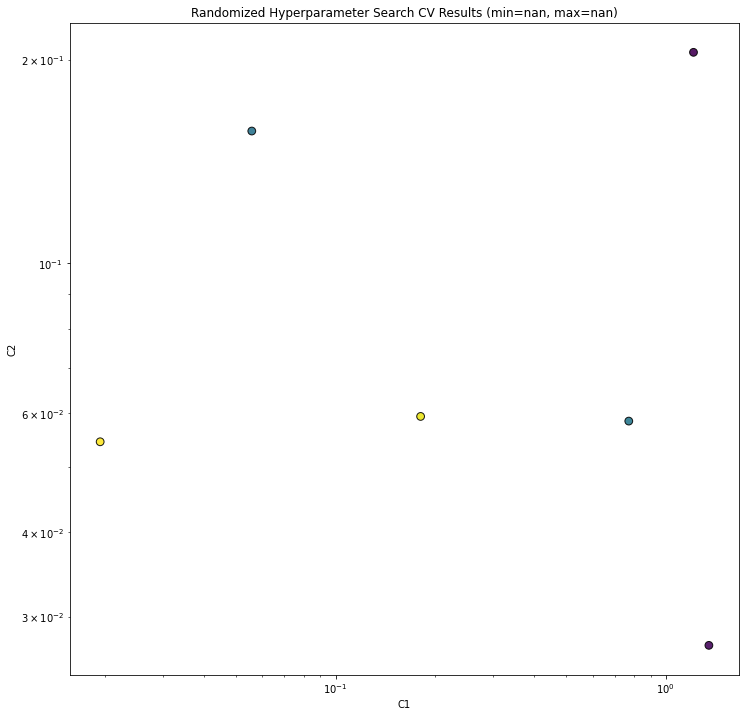

In [127]:
_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = [s for s in rs.cv_results_['mean_test_score']]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [128]:
best_crf = rs.best_estimator_
y_pred  =  best_crf.predict(X_test)

              precision    recall  f1-score   support

      is_nar       0.72      0.57      0.64      2089
     not_nar       0.84      0.91      0.88      5227

    accuracy                           0.81      7316
   macro avg       0.78      0.74      0.76      7316
weighted avg       0.81      0.81      0.81      7316



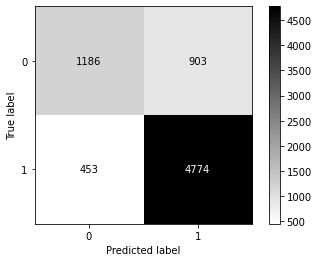

In [129]:
feature_utils.get_prediction_report(flatten(y_test),flatten(y_pred),crf.classes_)

In [22]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(best_crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(best_crf.transition_features_).most_common()[-20:])

Top likely transitions:
is_nar -> is_nar  2.033938
not_nar -> not_nar 1.556495
not_nar -> is_nar  -1.478059
is_nar -> not_nar -1.738426

Top unlikely transitions:
is_nar -> is_nar  2.033938
not_nar -> not_nar 1.556495
not_nar -> is_nar  -1.478059
is_nar -> not_nar -1.738426
